# Color Discretization

### ColorDiscretizer demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
from utils.color_discretizer import ColorDiscretizer
from utils.color_utils import YUV_to_RGB, RGB_to_YUV
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
cd = ColorDiscretizer()
imdir = "../data/iccv09Data/images/"
cd.train(imdir, 30)

../utils/color_discretizer.py:77: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)


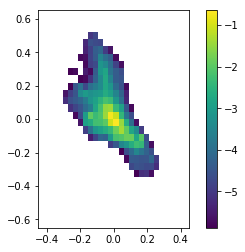

In [5]:
cd.plot_heatmap()

In [6]:
from matplotlib.pyplot import imread
from utils.color_utils import RGB_to_YUV

image = imread("../data/iccv09Data/images/0000051.jpg").astype(np.dtype("float32"))
YUVimage = RGB_to_YUV(image)
UVimage = YUVimage[:, :, 1:]
UVpixels = np.reshape(UVimage, newshape=[-1, 2])

In [7]:
cd.categorize(UVimage)

array([[147, 147, 147, ..., 147, 147, 147],
       [147, 147, 147, ..., 147, 147, 147],
       [147, 147, 147, ..., 147, 147, 147],
       ...,
       [ 82,  82,  82, ...,  96,  96,  96],
       [ 82,  82,  82, ...,  96,  96,  96],
       [ 82,  82,  82, ...,  96,  96,  96]])

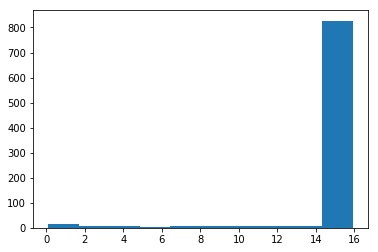

In [8]:
plt.hist(cd.weights.values())
plt.show()

In [9]:
unique, counts = np.unique(cd.categorize(UVimage), return_counts=True)

In [10]:
unique

array([ 82,  94,  95,  96, 108, 109, 110, 121, 122, 123, 135, 136, 147])

In [11]:
counts

array([ 7749,     9,  1559,  3439,  1404,  7738,    49,   109, 15602,
        1085, 15919, 10219, 11919])

In [12]:
categories_distributions = np.abs(np.random.rand(4, 4, cd.n_categories))
cd.UVpixels_from_distribution(categories_distributions)

array([[[-0.02647252,  0.06813544],
        [-0.02061439,  0.0607258 ],
        [-0.02877918,  0.0684165 ],
        [-0.02932159,  0.0837886 ]],

       [[-0.02717825,  0.06421427],
        [-0.03567849,  0.06928601],
        [-0.02540061,  0.08975392],
        [-0.0316158 ,  0.06945019]],

       [[-0.0367954 ,  0.0781814 ],
        [-0.02358414,  0.07328728],
        [-0.03115732,  0.06428135],
        [-0.02910167,  0.0830039 ]],

       [[-0.02671613,  0.07637322],
        [-0.02263346,  0.06478584],
        [-0.03655737,  0.0724297 ],
        [-0.02111903,  0.07213007]]])

### L2 cost of categorizing

In [13]:
image = imread("../data/iccv09Data/images/0002136.jpg").astype(np.dtype("float32"))
YUVimage = RGB_to_YUV(image)
UVimage = YUVimage[:, :, 1:]
Yimage = YUVimage[:, :, :1]

In [14]:
pixels_categories = cd.categorize(UVimage)

pixel_categories_onehot = to_categorical(pixels_categories, num_classes=cd.n_categories)

reconstructed_UVimage = cd.UVpixels_from_distribution(pixel_categories_onehot)

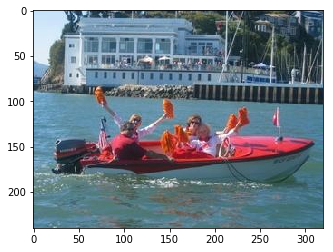

In [15]:
plt.imshow(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2))/255.)
plt.show()

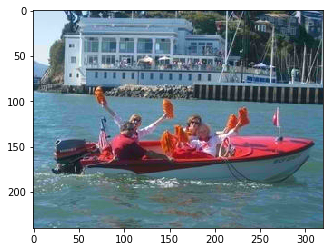

In [16]:
plt.imshow(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2)) / 255)
plt.show()

In [17]:
np.linalg.norm(reconstructed_UVimage - UVimage, axis = (0, 1)) / len(UVpixels) / np.std(UVpixels, axis = 0)

array([0.0007355 , 0.00108955])

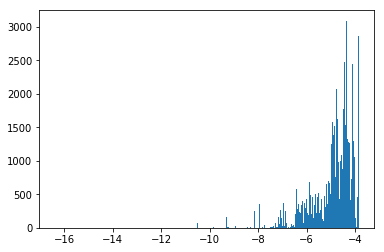

In [18]:
plt.hist(np.reshape(np.log(np.abs(reconstructed_UVimage - UVimage)), [-1, 1]), bins = 1000)
plt.show()

Note that sometimes, the return to RGB space goes over 255 or below 0, so we added a correction to the function.

In [19]:
print(np.max(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2),correction = False)))
print(np.min(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2),correction = False)))

255.00000000000006
-2.1282261841509484e-14


In [20]:
print(np.max(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2), correction = False)))
print(np.min(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2), correction = False)))

262.75519686947
-7.681020067230035


### Thresholding out rare pixels

../utils/color_discretizer.py:77: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)


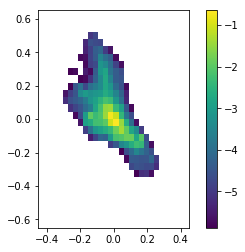

Remaining colors: 179


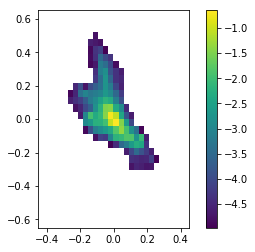

Remaining colors: 143


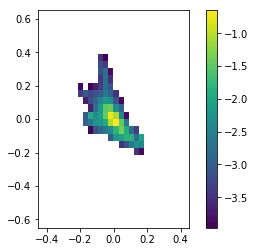

Remaining colors: 81


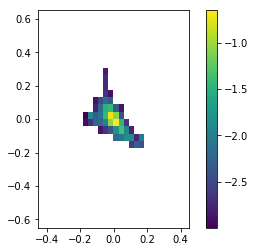

Remaining colors: 48


In [21]:
for threshold in [.000001, .00001, .0001, .001]:
    cd = ColorDiscretizer(threshold=threshold)
    imdir = "../data/iccv09Data/images/"
    cd.train(imdir, 30)
    cd.plot_heatmap()
    print("Remaining colors: {}".format(np.sum(cd.heatmap > cd.threshold)))

### Using a fixed number of categories

../utils/color_discretizer.py:77: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)


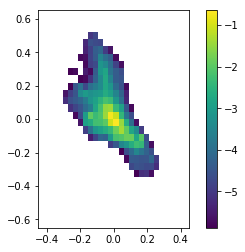

Remaining colors: 179


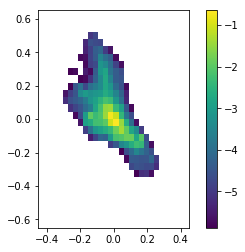

Remaining colors: 179


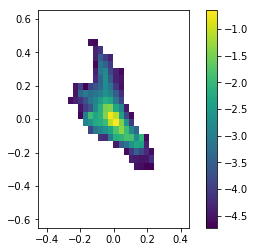

Remaining colors: 128


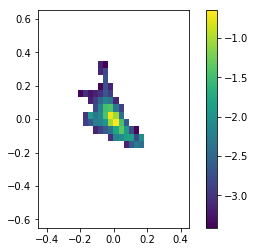

Remaining colors: 64


In [22]:
for max_cat in [250,200,128,64]:
    cd = ColorDiscretizer(threshold=.000001,max_categories=max_cat)
    imdir = "../data/iccv09Data/images/"
    cd.train(imdir, 30)
    cd.plot_heatmap()
    print("Remaining colors: {}".format(np.sum(cd.heatmap > cd.threshold)))